In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
from IPython.display import display
import neurokit2 as nk
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.signal
from heartpy import filtering
from scipy.fft import fft, ifft

# Set matplotlib parameters for displaying graphs
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [10, 5]  # Bigger images
plt.rcParams['font.size']= 14

pd.set_option('display.max_columns', None)

In [74]:
########################################################################################################
#                                          PART 206                                                    #
########################################################################################################

# Using video timestamps, record min and sec for each trial start and trust feedback, insert into lists
# Estimate the offset between video time and BioPac time and subtract in while loop
# Printed values are the sample numbers where you should start to look for trigger onsets
# Each sample is 0.0005 seconds, we only need .01 seconds resolution, so to the nearest 20 samples

mins_201 = [1,8,13,18,23,29,33,38,42,48,53,56]
secs_201 = [58,46,10,14,25,21,36,33,25,48,1,59]

mins_202 = [1,10,15,20,25,29,34,44,49,53,58,63]
secs_202 = [4,1,27,24,40,59,35,25,2,31,34,31]

mins_203 = [2,8,15,19,25,29,34,44,49,53,58,63]
secs_203 = [28,57,22,57,7,23,12,48,16,35,20,35]

mins_204 = [1,12,16,20,25,29,36,40,44,48,52,56]
secs_204 = [59,42,37,54,41,53,30,36,5,15,7,3]

mins_205 = [2,10,17,22,28,34,40,46,51,56,62,68]
secs_205 = [13,38,17,57,48,14,26,5,29,45,40,25]

mins_206 = [4,12,17,22,27,32,36,41,46,51,55,60]
secs_206 = [11,32,24,5,0,5,59,34,44,15,53,23]

mins_207 = [2,8,13,17,22,27,32,36,41,45,49,54]
secs_207 = [52,45,17,44,23,47,15,42,10,39,43,25]

mins_208 = [2,10,17,22,27,32,36,41,45,50,55,60]
secs_208 = [8,3,4,10,13,1,32,10,49,30,18,3]

mins_209 = [2,7,12,16,20,25,29,36,39,43,47,52]
secs_209 = [4,42,20,28,56,3,4,6,59,57,49,19]

mins_210 = [2,9,15,19,23,28,32,36,40,43,47,52]
secs_210 = [1,52,9,38,48,2,8,10,5,54,57,14]

mins_211 = [2,8,12,16,19,23,26,30,34,37,41,45]
secs_211 = [55,2,18,0,47,24,52,33,13,54,56,44]

mins_212 = [1,9,13,18,22,27,32,36,41,45,49,54]
secs_212 = [56,16,55,20,48,25,13,34,18,22,15,2]

mins_213 = [2,10,16,21,26,31,35,40,45,50,54,62]
secs_213 = [18,11,15,29,24,1,44,49,32,15,55,34]

mins_215 = [2,9,14,19,23,28,32,36,40,45,49,53]
secs_215 = [23,6,19,0,51,3,25,48,57,4,28,41]

In [2]:
participant_no = '206' #Change this everytime idiot

In [80]:
index = []

i=0
while i<12:
    index.append((mins_215[i]*60+secs_215[i])*2000-44580) #This number is different each subject and
    #must be found be looking at second dip
    i+=1
    
print(index)

[241420, 1047420, 1673420, 2235420, 2817420, 3321420, 3845420, 4371420, 4869420, 5363420, 5891420, 6397420]


<IPython.core.display.Javascript object>


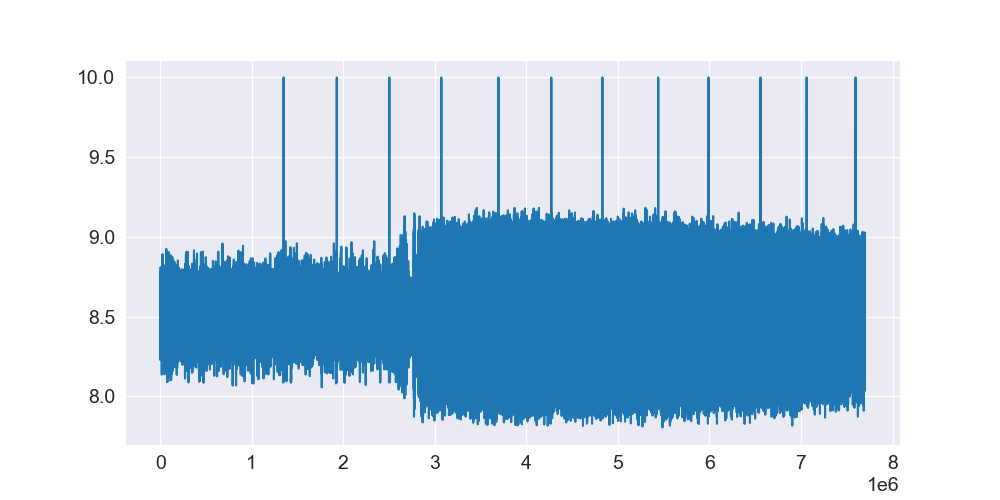

<AxesSubplot:>

In [4]:
filename = 'data/part'+participant_no+'/part'+participant_no+'_pilot.acq'
# Read in data directly from .acq file and rename dataframe columns
# change the participant number in first line

data, sampling_rate = nk.read_acqknowledge(filename)
data = data.rename(columns={"RSP, X, RSPEC-R": "RSP", "DTU100 - Trigger View, AMI / HLT - A11": "TRIG",
                            "EDA, X, PPGED-R": "EDA", "ECG, X, RSPEC-R": "ECG"})

data['TRIG'].plot()
#data['TRIG'][index[1]-300:index[1]+300].plot()



In [81]:
end_timestamps = []
for index, value in enumerate(data['TRIG']):
    if value > 9.5:
        end_timestamps.append(index)
print(end_timestamps[::2])

[977208, 1603864, 2170832, 2726492, 3254940, 3769372, 4294953, 4803969, 5288471, 5810480, 6297947, 6784770]


<IPython.core.display.Javascript object>


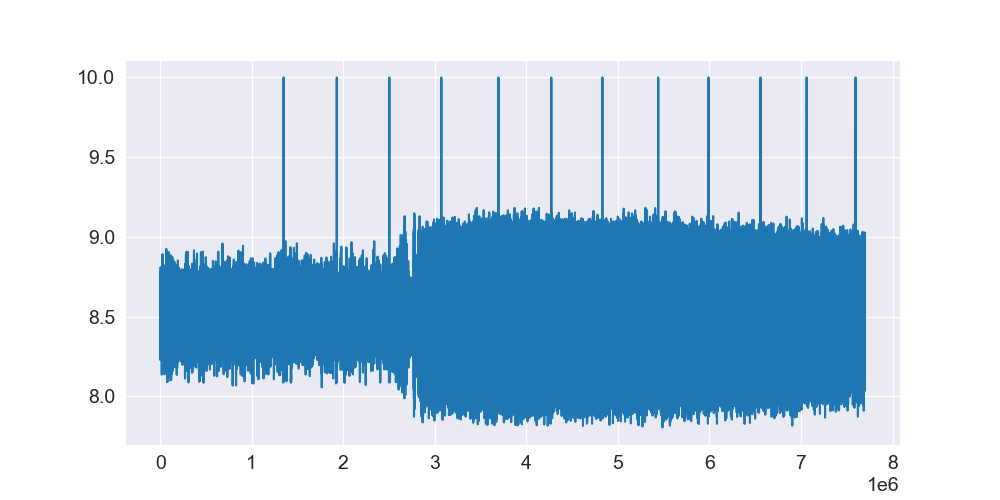

<AxesSubplot:>

In [4]:
filename = 'data/part'+participant_no+'/part'+participant_no+'_pilot.acq'
# Read in data directly from .acq file and rename dataframe columns
# change the participant number in first line

data, sampling_rate = nk.read_acqknowledge(filename)
data = data.rename(columns={"RSP, X, RSPEC-R": "RSP", "DTU100 - Trigger View, AMI / HLT - A11": "TRIG",
                            "EDA, X, PPGED-R": "EDA", "ECG, X, RSPEC-R": "ECG"})

data['TRIG'].plot()
#data['TRIG'][index[1]-300:index[1]+300].plot()



In [58]:
fs = 2000# Sample frequency (Hz)

f0 = .8  # Frequency to be removed from signal (Hz)

Q = .1 # Quality factor

# Design notch filter

b, a = scipy.signal.iirnotch(f0, Q, fs)
print(b)
print(a)

[ 0.98758894 -1.97517164  0.98758894]
[ 1.         -1.97517164  0.97517788]


<IPython.core.display.Javascript object>


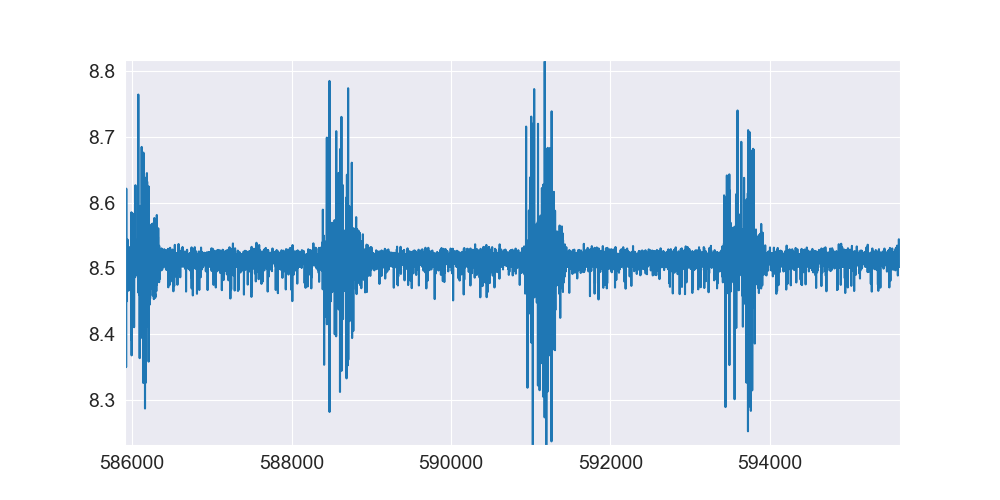

In [59]:
sos = np.concatenate((b,a))
y_sos = scipy.signal.sosfiltfilt(sos, data['TRIG'])
plt.figure()
plt.plot(y_sos)

[   0.97490393   -9.74182365   43.81297286 -116.78656083  204.32606765
 -245.17111992  204.32606765 -116.78656083   43.81297286   -9.74182365
    0.97490393]
[   1.           -9.9418043    44.48521279 -117.9763787   205.36028254
 -245.162317    203.28304695 -115.6017699    43.14890892   -9.54561899
    0.95043768]


<IPython.core.display.Javascript object>


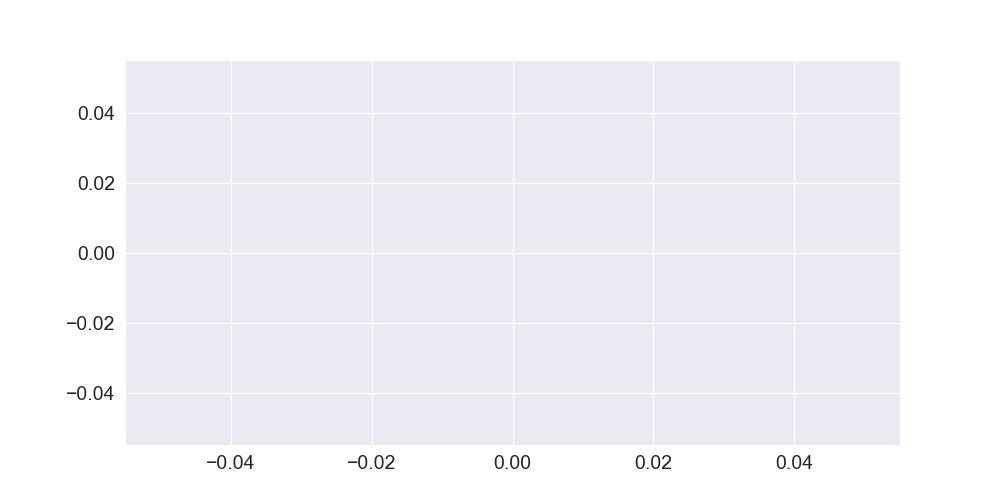

In [35]:
fs = 2000# Sample frequency (Hz)

f0 = [10,15]  # Frequency to be removed from signal (Hz)

Q = 5.0  # Quality factor

# Design notch filter
order = 5

b, a = scipy.signal.butter(order,f0,btype='bandstop',fs=fs)
print(b)
print(a)

sos = np.concatenate((b,a))
y_sos = scipy.signal.filtfilt(b,a, data['TRIG'])
plt.figure()
plt.plot(y_sos)

In [35]:
from heartpy import filtering

In [51]:
filtered = filtering.filter_signal(data['TRIG'], cutoff = 1.2, sample_rate =2000.0, order =5, filtertype='notch')

<IPython.core.display.Javascript object>


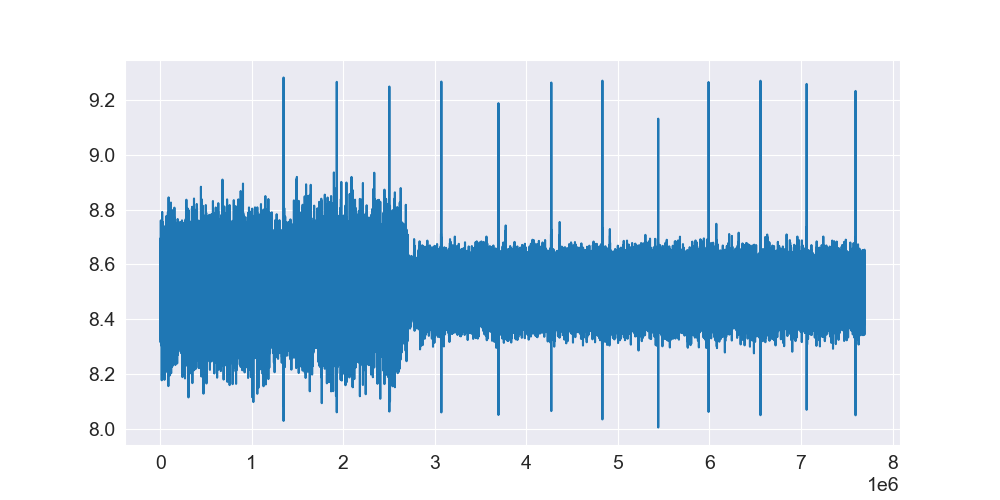

In [52]:
plt.figure()
plt.plot(filtered)

In [53]:
filtered = filtering.filter_signal(data['TRIG'], cutoff = [10,15], sample_rate = 2000.0, order =10, filtertype='bandpass')

<IPython.core.display.Javascript object>


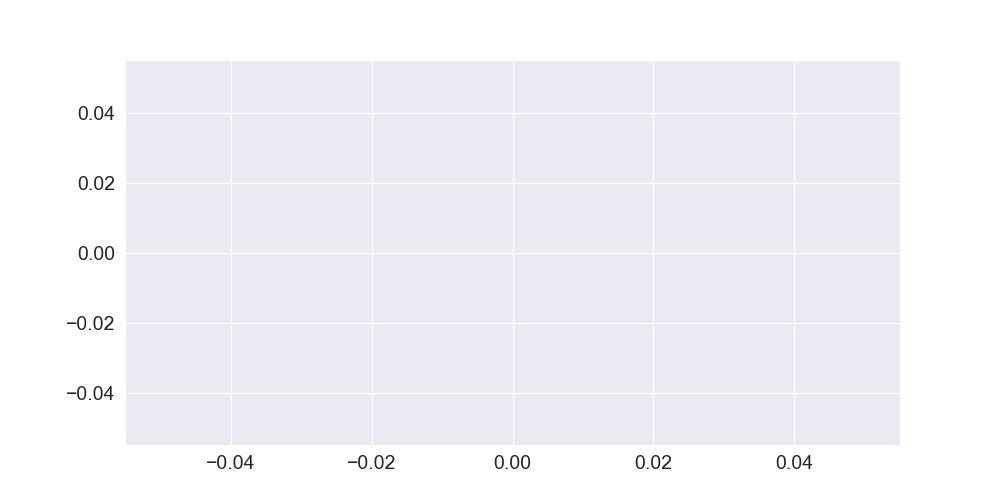

In [54]:
plt.figure()
plt.plot(filtered)

In [56]:
ummm = data['TRIG'] - filtered

<IPython.core.display.Javascript object>


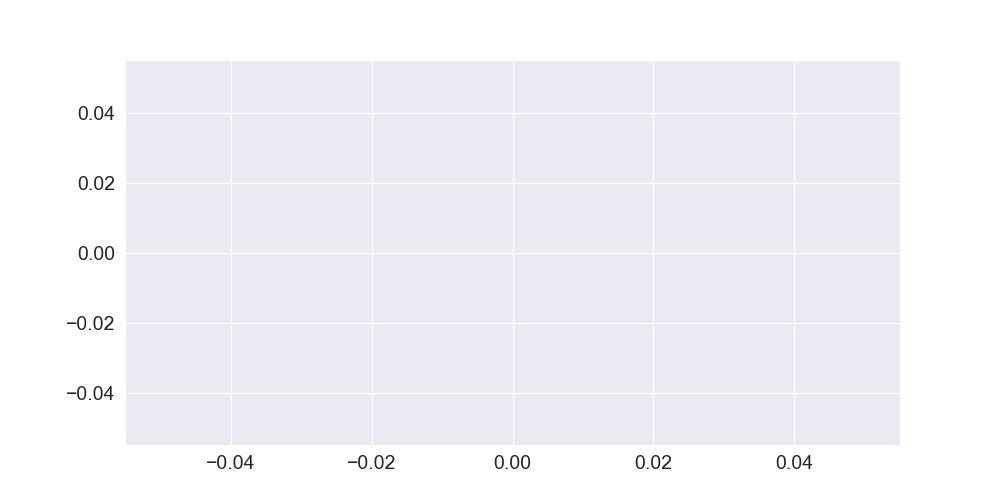

In [57]:
plt.figure()
plt.plot(ummm)

<IPython.core.display.Javascript object>


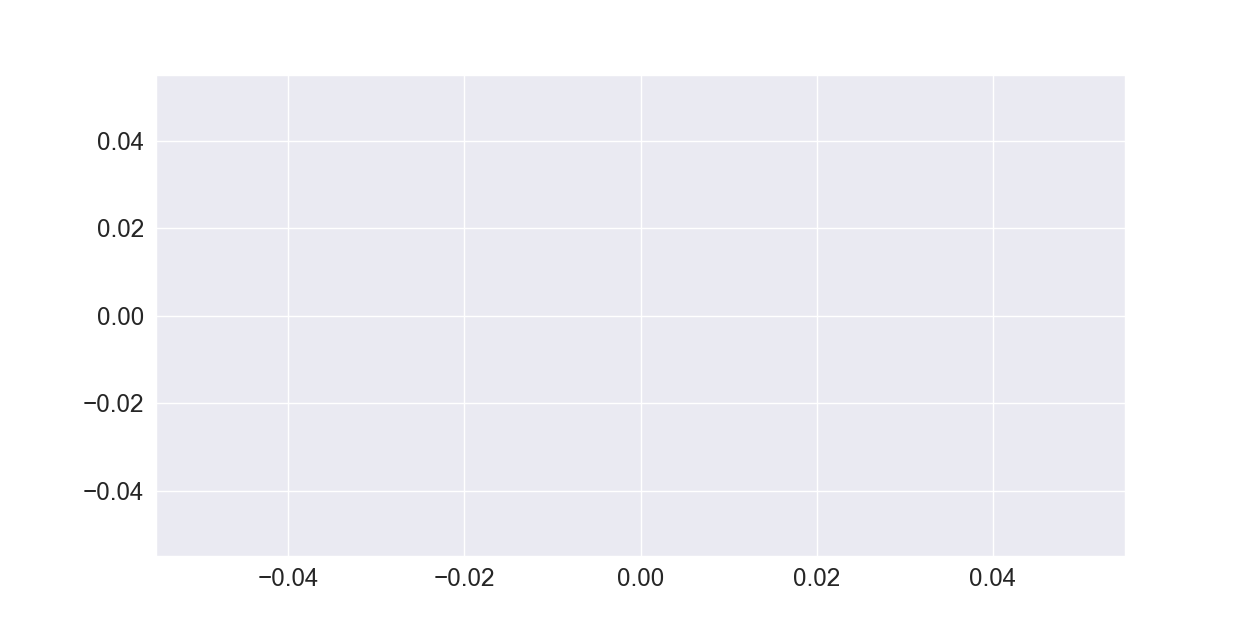

In [6]:
fs = 2000.0  # Sample frequency (Hz)

f0 = 1000.0  # Frequency to be removed from signal (Hz)

Q = .7 # Quality factor

# Design notch filter

b, a = scipy.signal.iirnotch(f0, Q, fs)

yy = scipy.signal.lfilter(b, a, data['TRIG'])
plt.figure()
plt.plot(yy[444000:448000])

<IPython.core.display.Javascript object>


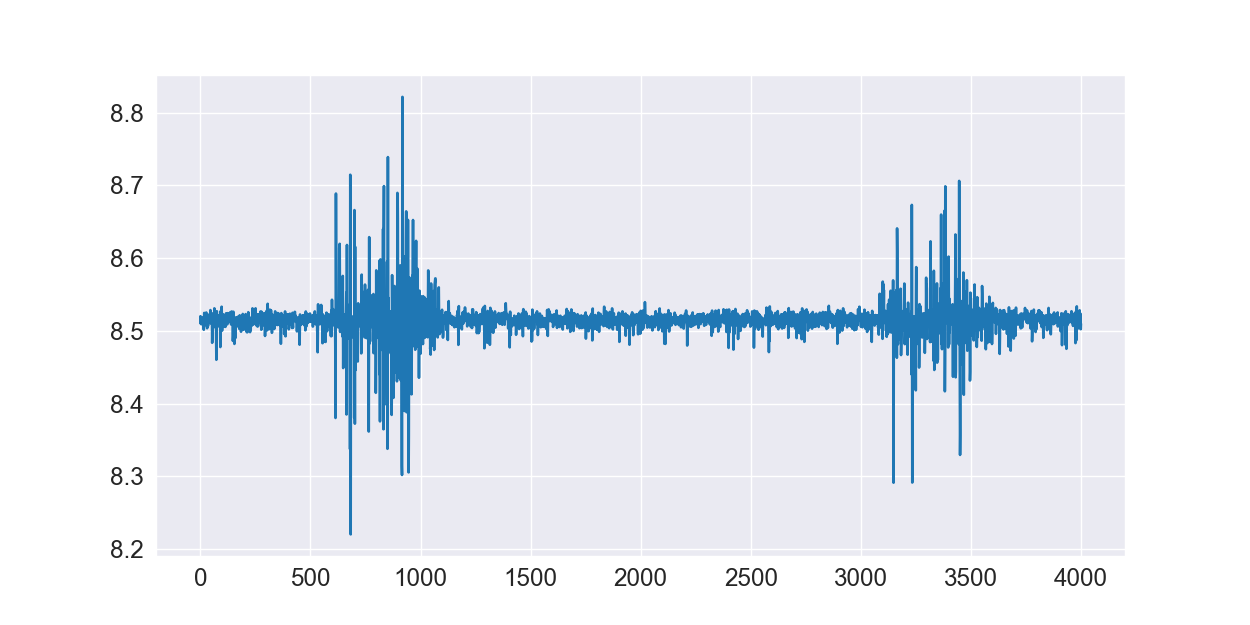

In [27]:
fs = 2000.0  # Sample frequency (Hz)

f0 = [800.0,999] # Frequency to be removed from signal (Hz)

Q = 100 # Quality factor

# Design notch filter

order = 1
b, a = scipy.signal.butter(order,f0,btype='bandstop',fs=fs)

yy = scipy.signal.lfilter(b, a, data['TRIG'])
plt.figure()
plt.plot(yy[444000:448000])

In [7]:
fs = 2000.0  # Sample frequency (Hz)

f0 = 500.0  # Frequency to be removed from signal (Hz)

Q = 5.0  # Quality factor

# Design notch filter

b, a = scipy.signal.iirnotch(f0, Q, fs)
# Frequency response

freq, h = scipy.signal.freqz(b, a, fs=fs)

<IPython.core.display.Javascript object>


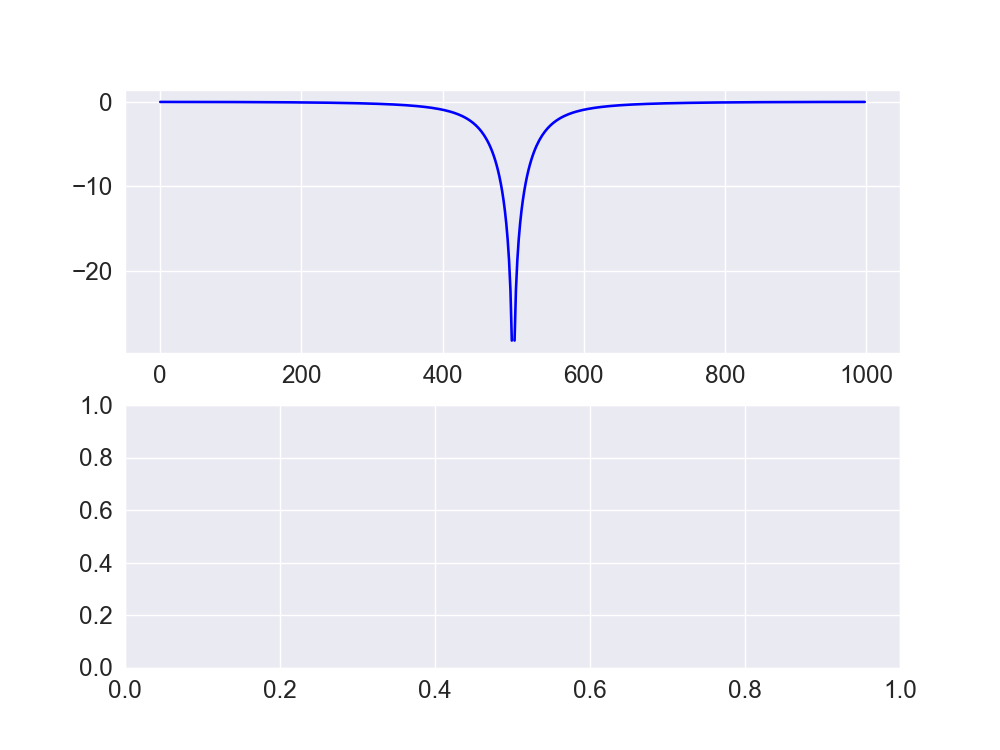

C:\Users\BIOPACMan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')

<IPython.core.display.Javascript object>


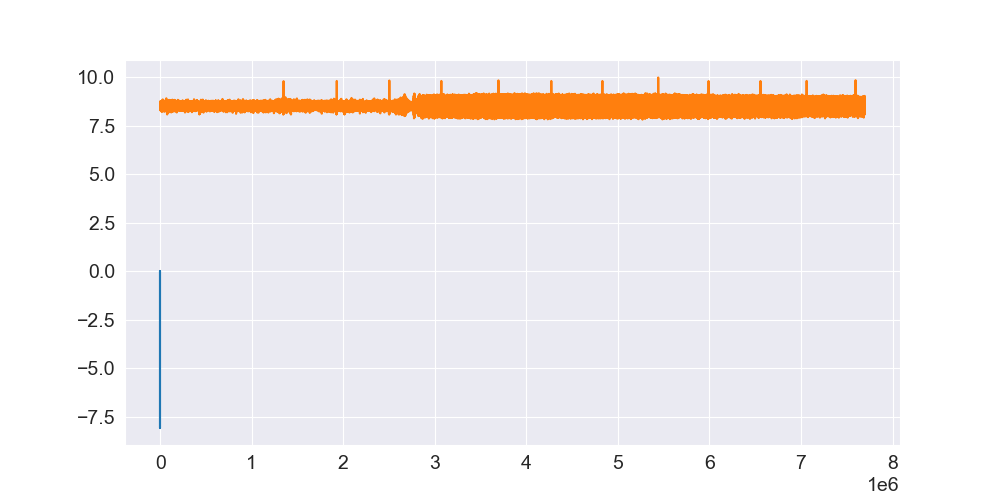

<IPython.core.display.Javascript object>


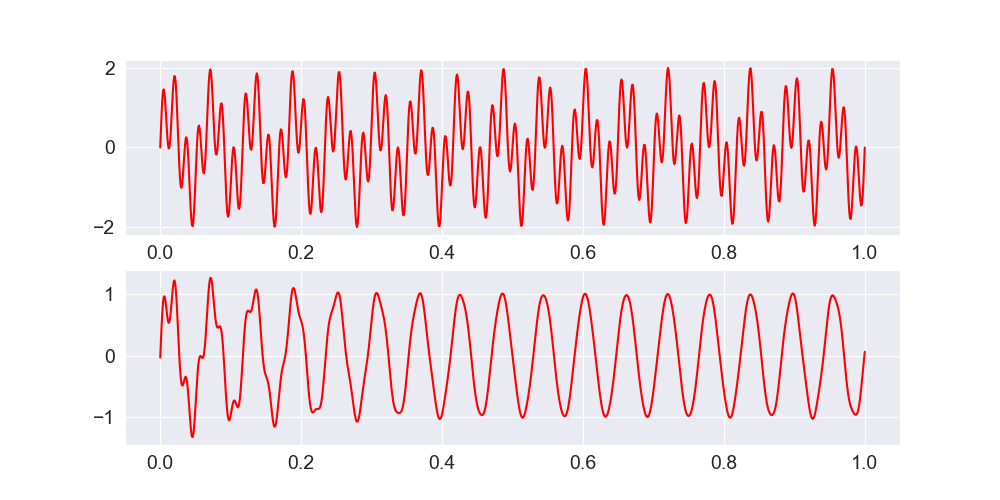

In [25]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

# Create/view notch filter
samp_freq = 1000  # Sample frequency (Hz)
notch_freq = 60.0  # Frequency to be removed from signal (Hz)
quality_factor = 30.0  # Quality factor
b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
freq, h = signal.freqz(b_notch, a_notch, fs = samp_freq)
plt.figure('filter')
plt.plot( freq, 20*np.log10(abs(h)))

# Create/view signal that is a mixture of two frequencies
f1 = 17
f2 = 60
t = np.linspace(0.0, 1, 1_000)
y_pure = np.sin(f1 * 2.0*np.pi*t) + np.sin(f2 * 2.0*np.pi*t) 
plt.figure('result')
plt.subplot(211)
plt.plot(t, y_pure, color = 'r')

# apply notch filter to signal
y_notched = signal.filtfilt(b_notch, a_notch, y_pure)

# plot notch-filtered version of signal
plt.subplot(212)
plt.plot(t, y_notched, color = 'r')

<IPython.core.display.Javascript object>


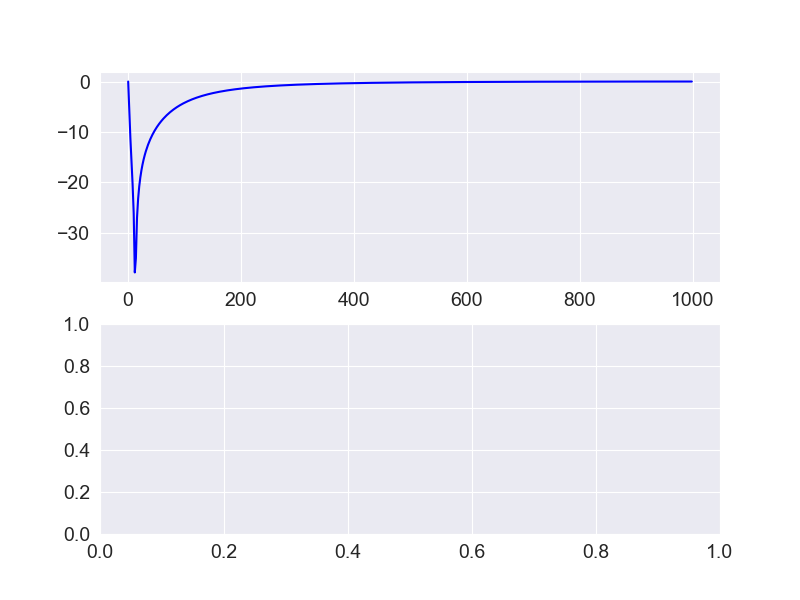

In [26]:
fs = 2000.0  # Sample frequency (Hz)

f0 = 12.5  # Frequency to be removed from signal (Hz)

Q = .1 # Quality factor

# Design notch filter

b, a = scipy.signal.iirnotch(f0, Q, fs)


# Frequency response

freq, h = scipy.signal.freqz(b, a, fs=fs)

# Plot

fig, ax = plt.subplots(2, 1, figsize=(8, 6))

ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')

In [24]:
p,pxx = scipy.signal.periodogram(data['TRIG'].to_numpy(),fs=2000)

<IPython.core.display.Javascript object>


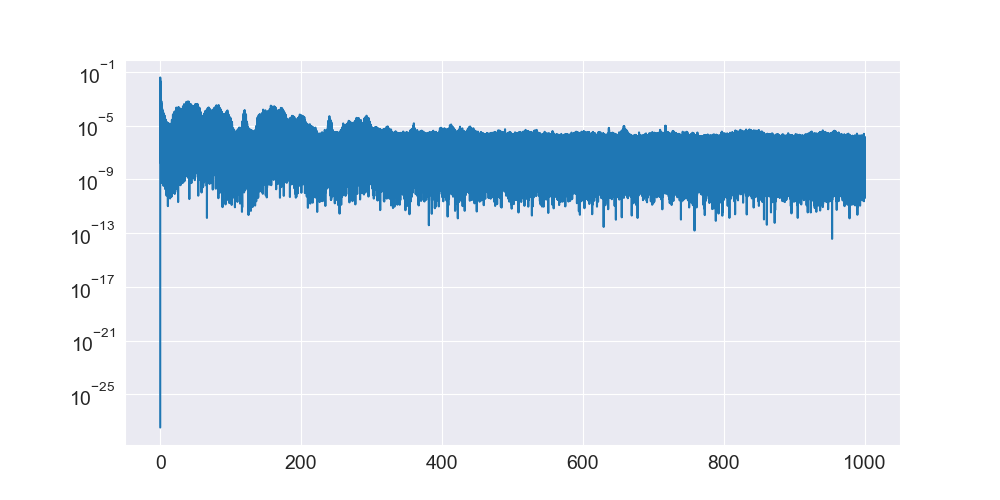

In [25]:
plt.figure()
plt.semilogy(p,pxx)

In [8]:
f = fft(data['TRIG'].to_numpy())

<IPython.core.display.Javascript object>


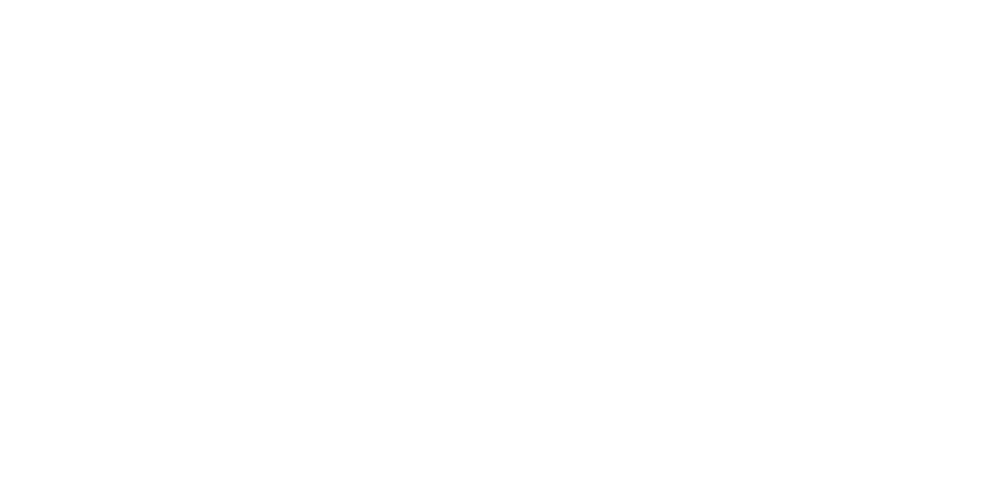

C:\Users\BIOPACMan\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [10]:
plt.figure()
plt.semilogy(f)

In [20]:
np.shape(data['TRIG'])

(7696494,)

<IPython.core.display.Javascript object>


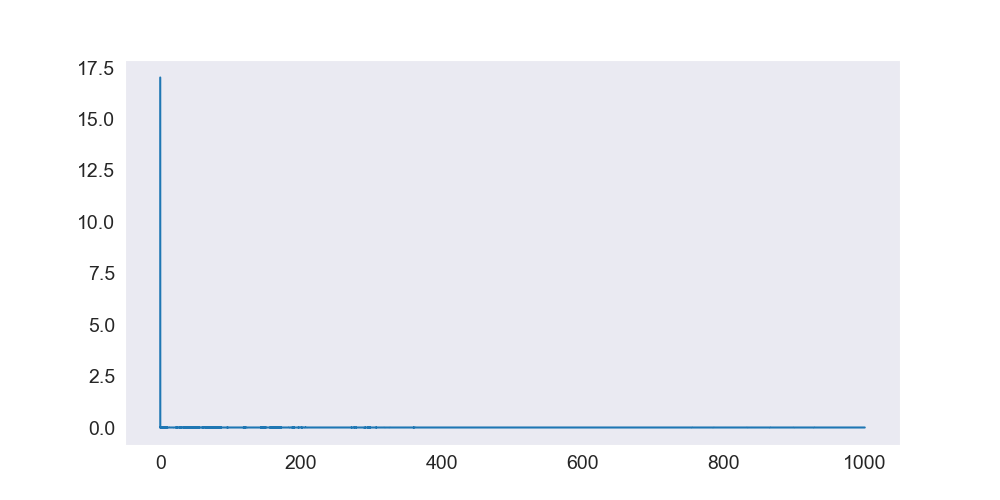

In [23]:
N = 7696494

# sample spacing

T = 1/2000

x = np.linspace(0.0, N*T, N)



yf = fft(data['TRIG'].to_numpy())

xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure()

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

plt.grid()

plt.show()